In [1]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers
from itertools import compress

In [22]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(
        self,
        patch_path,
        csv_path,
        input_var,
        output_var,
        batch_size,
        shuffle=False,
        num_files=None,
    ):

        super().__init__()

        patch_files = sorted(glob(join(patch_path, "*.nc")))
        csv_files = sorted(glob(join(csv_path, "track_step_*.csv")))

        self.patch_data_list = []
        for patch_file in patch_files[:num_files]:
            temp_ds = xr.open_dataset(patch_file)
            self.patch_data_list.append(temp_ds[input_var])
            temp_ds.close()

        self.csv_data_list = []
        for csv_file in csv_files[:num_files]:
            temp_csv = pd.read_csv(csv_file)
            self.csv_data_list.append(temp_csv[output_var].to_xarray().rename({'index': 'p'}))

        self.translate_dict = []
        for i, ds in enumerate(self.patch_data_list):
            for ind in range(ds.dims['p']):
                self.translate_dict.append((i, ind))

        self.input_var = input_var
        self.output_var = output_var
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __getitem__(self, index):
        exp_indices = self.translate_dict[self.batch_size * index:self.batch_size * (index + 1)]
        if False:  # exp_indices[0][0] == exp_indices[-1][0]:
            X = self.patch_data_list[exp_indices[0][0]].isel(p=slice(exp_indices[0][1], exp_indices[-1][1] + 1)).expand_dims("channel", axis=-1)
            y = self.csv_data_list[exp_indices[0][0]].isel(p=slice(exp_indices[0][1], exp_indices[-1][1] + 1))
        elif False:  # exp_indices[0][0] + 1 == exp_indices[-1][0]:
            exp_ind_0 = list(compress(exp_indices, map(lambda x: x[0] == exp_indices[0][0], exp_indices)))
            exp_ind_1 = list(compress(exp_indices, map(lambda x: x[0] == exp_indices[-1][0], exp_indices)))
            X = xr.concat([
                self.patch_data_list[exp_ind_0[0][0]].isel(p=slice(exp_ind_0[0][1], exp_ind_0[-1][1] + 1)).expand_dims("channel", axis=-1),
                self.patch_data_list[exp_ind_1[0][0]].isel(p=slice(exp_ind_1[0][1], exp_ind_1[-1][1] + 1)).expand_dims("channel", axis=-1),
            ], dim='p')
            y = xr.concat([
                self.csv_data_list[exp_ind_0[0][0]].isel(p=slice(exp_ind_0[0][1], exp_ind_0[-1][1] + 1)),
                self.csv_data_list[exp_ind_1[0][0]].isel(p=slice(exp_ind_1[0][1], exp_ind_1[-1][1] + 1)),
            ], dim='p')
        else:
            X = self.patch_data_list[exp_indices[0][0]].isel(p=exp_indices[0][1])
            y = self.csv_data_list[exp_indices[0][0]].isel(p=exp_indices[0][1])
            for ind in exp_indices[1:]:
                X = xr.concat([X, self.patch_data_list[ind[0]].isel(p=ind[1])], dim="p")
                y = xr.concat([y, self.csv_data_list[ind[0]].isel(p=ind[1])], dim="p")
            X.expand_dims("channel", axis=-1)
        return (X.to_array('temp').squeeze('temp'), y.to_array().transpose())

    def __len__(self):
        return len(self.translate_dict) // self.batch_size

In [31]:
patch_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/"
csv_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/"
variables = ["REFL_COM_curr"]
csv_variables = ["major_axis_length", "minor_axis_length"]
data_gen = DataGenerator(patch_path, csv_path, variables, csv_variables, 32, num_files=None)

In [32]:
[ds.dims['p'] for ds in data_gen.patch_data_list]

[370,
 339,
 303,
 253,
 126,
 77,
 171,
 71,
 195,
 139,
 130,
 123,
 164,
 121,
 140,
 207,
 152,
 136,
 70,
 166,
 141,
 120,
 151,
 158,
 90,
 247,
 57,
 117,
 138,
 80,
 130,
 215,
 92,
 50,
 233,
 216,
 235,
 206,
 198,
 219,
 316,
 549,
 291,
 418,
 97,
 95,
 186,
 453,
 505,
 386,
 733,
 562,
 464,
 464,
 519,
 433,
 144,
 116,
 360,
 245,
 266,
 355,
 218,
 298,
 509,
 470,
 719,
 390,
 243,
 383,
 332,
 611,
 720,
 588,
 485,
 452,
 970,
 678,
 542,
 479,
 580,
 504,
 395,
 480,
 774,
 676,
 799,
 988,
 717,
 759,
 938,
 986,
 212,
 259,
 97,
 235,
 82,
 166,
 45,
 121,
 130,
 53,
 115,
 144,
 216,
 535,
 259,
 388,
 200,
 283,
 404,
 462,
 233,
 184,
 260,
 82,
 186,
 410,
 296,
 118,
 128,
 183,
 229,
 263,
 504,
 290,
 162,
 404,
 362,
 487,
 567,
 367,
 323,
 438,
 450,
 288,
 238,
 346,
 449,
 594,
 638,
 458,
 435,
 598,
 501,
 731,
 933,
 632,
 498,
 489,
 528,
 455,
 470,
 264,
 472,
 417,
 624,
 843,
 856,
 1071,
 751,
 899,
 1057,
 1147,
 879,
 1262,
 176,
 117,
 59

In [28]:
%%timeit
data_gen.__getitem__(0)

1.69 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
# Find a list of all the datafiles
patch_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/"
patch_files = sorted(glob(join(patch_path, "*.nc")))
patch_ds = xr.open_dataset(patch_files[0])
csv_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/"
csv_files = sorted(glob(join(csv_path, "track_step_*.csv")))
meta_ds = pd.read_csv(csv_files[0])

In [70]:
patch_ds[['REFL_COM_curr']].isel(p=0).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:        (row: 144, col: 144)
Coordinates:
    p              int32 0
  * row            (row) int32 0 1 2 3 4 5 6 7 ... 137 138 139 140 141 142 143
  * col            (col) int32 0 1 2 3 4 5 6 7 ... 137 138 139 140 141 142 143
Data variables:
    REFL_COM_curr  (row, col) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/36)
    Conventions:             CF-1.6
    title:                   NCARSTORM Storm Patches for run 20101024-0000 me...
    object_variable:         REFL_COM
    start_hour:              12
    end_hour:                35
    HRRR_alt_end_hour:       46
    ...                      ...
    single_step:             True
    label_type:              gamma
    model_map_file:          /glade/work/cbecker/hagelslag/mapfiles/ncar_stor...
    mask_file:               None
    run_date_format:         %Y%m%d-%H%M
    json:                    False>

In [4]:
meta_ds

,Step_ID,Track_ID,Ensemble_Name,Ensemble_Member,Run_Date,Valid_Date,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,...,eccentricity,major_axis_length,minor_axis_length,orientation,Matched,Max_Hail_Size,Num_Matches,Shape,Location,Scale
0,d01_REFL_COM_20101024-0000_12_13_000_00,d01_REFL_COM_20101024-0000_12_13_000,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 12:00:00+00:00,12,12,1,-98.41019,...,0.90735,51.23550,21.53869,1.41172,0,0,0,0,0,0
1,d01_REFL_COM_20101024-0000_12_13_000_01,d01_REFL_COM_20101024-0000_12_13_000,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 13:00:00+00:00,13,13,2,-97.69198,...,0.85356,26.92719,14.02906,1.13923,0,0,0,0,0,0
2,d01_REFL_COM_20101024-0000_12_12_001_00,d01_REFL_COM_20101024-0000_12_12_001,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 12:00:00+00:00,12,12,1,-95.15486,...,0.71815,8.65894,6.02569,0.74301,0,0,0,0,0,0
3,d01_REFL_COM_20101024-0000_12_13_002_00,d01_REFL_COM_20101024-0000_12_13_002,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 12:00:00+00:00,12,12,1,-94.39792,...,0.58687,7.89825,6.39509,-1.28875,0,0,0,0,0,0
4,d01_REFL_COM_20101024-0000_12_13_002_01,d01_REFL_COM_20101024-0000_12_13_002,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 13:00:00+00:00,13,13,2,-94.21008,...,0.91899,27.65443,10.90375,0.32912,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,d01_REFL_COM_20101024-0000_35_35_238_00,d01_REFL_COM_20101024-0000_35_35_238,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-85.94177,...,0.44428,6.31100,5.65396,1.29480,0,0,0,0,0,0
366,d01_REFL_COM_20101024-0000_35_35_239_00,d01_REFL_COM_20101024-0000_35_35_239,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-85.16997,...,0.85947,79.05277,40.41106,0.12811,0,0,0,0,0,0
367,d01_REFL_COM_20101024-0000_35_35_240_00,d01_REFL_COM_20101024-0000_35_35_240,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-88.18374,...,0.92145,18.05184,7.01316,0.99009,0,0,0,0,0,0
368,d01_REFL_COM_20101024-0000_35_35_241_00,d01_REFL_COM_20101024-0000_35_35_241,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-82.50549,...,0.93744,14.44305,5.02817,-0.19595,0,0,0,0,0,0


In [5]:
# Pull selected variables from patch files and join into a single DataSet
num_files = 100
variables = ["i", "j", "REFL_COM_curr"]
data_list = []
for p, patch_file in enumerate(patch_files[0:num_files]):
    if p % 10 == 0:
        print(p, patch_file)
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
data = xr.concat(data_list, dim="p")

0 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20101024-0000_d01_model_patches.nc
10 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110201-0000_d01_model_patches.nc
20 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110326-0000_d01_model_patches.nc
30 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110414-0000_d01_model_patches.nc
40 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110425-0000_d01_model_patches.nc
50 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110522-0000_d01_model_patches.nc
60 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110605-0000_d01_model_patches.nc
70 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110615-0000_d01_model_patches.nc
80 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110625-0000_d01_model_patches.nc
90 /glade/scratch/lverhoef/WR

In [6]:
# Pull variables from csv files and join into an array
csv_variables = ["major_axis_length", "minor_axis_length"]
csv_data_list = []
for p, csv_file in enumerate(csv_files[0:num_files]):
    if p % 10 == 0:
        print(p, csv_file)
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
csv_data = xr.concat(csv_data_list, dim="p")

0 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20101024-0000.csv
10 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110201-0000.csv
20 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110326-0000.csv
30 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110414-0000.csv
40 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110425-0000.csv
50 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110522-0000.csv
60 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110605-0000.csv
70 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110615-0000.csv
80 /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110625-0000.csv
90 /glade/scratch/lverhoef/WRF_all/tra

In [7]:
# Create DataArrays for input and output data
input_data = data["REFL_COM_curr"].expand_dims("channel", axis=-1)
output_data = csv_data.to_array().transpose()
del data
del csv_data

In [8]:
# Display shapes
print(input_data.shape)
print(output_data.shape)

(33403, 144, 144, 1)
(33403, 2)


In [9]:
# Find indices to split data into 70% training, 10% validation, and 20% test. The training and validation data are shuffled, while the test data is temporally different.
rng = np.random.default_rng()
split_point_1 = int(0.7 * input_data.shape[0])
split_point_2 = int(0.8 * input_data.shape[0])
train_val_indices = np.arange(0, split_point_2)
rng.shuffle(train_val_indices)
train_indices = train_val_indices[:split_point_1]
val_indices = train_val_indices[split_point_1:]
test_indices = np.arange(split_point_2, input_data.shape[0])

In [10]:
# Normalize the training input data and actually evaluate the input_train array which will be fed into the network
input_train = input_data.values[train_indices]
scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
scale_stats.loc[0, "mean"] = input_train.mean()
scale_stats.loc[0, "sd"] = input_train.std()
input_train_norm = (input_train - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [11]:
# Normalize the validation data
input_val = input_data.values[val_indices]
input_val_norm = (input_val - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [12]:
# Normalize the test input data and generate the test dataset
input_test = input_data.values[test_indices]
input_test_norm = (input_test - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [13]:
# Split output into train, test, and validation sets
output_train = output_data[train_indices]
output_val = output_data[val_indices]
output_test = output_data[test_indices]

In [13]:
gdl_model = models.Sequential()
gdl_model.add(layers.BatchNormalization(input_shape=(144, 144, 1)))
gdl_model.add(GDL_layers.RotEquivConv2D(32, (3, 3), rot_axis=False))
gdl_model.add(GDL_layers.RotEquivPool2D((2, 2)))
gdl_model.add(GDL_layers.RotEquivConv2D(32, (3, 3)))
gdl_model.add(GDL_layers.RotEquivPool2D((2, 2)))
gdl_model.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
gdl_model.add(GDL_layers.RotEquivPool2D((2, 2)))
gdl_model.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
gdl_model.add(GDL_layers.RotEquivPool2D((2, 2)))
gdl_model.add(GDL_layers.RotEquivConv2D(128, (3, 3)))
gdl_model.add(GDL_layers.RotInvPool())
gdl_model.add(layers.Flatten())
gdl_model.add(layers.Dense(2))

In [14]:
gdl_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 144, 144, 1)      4         
 hNormalization)                                                 
                                                                 
 rot_equiv_conv2d_15 (RotEqu  (None, 142, 142, 4, 32)  320       
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_12 (RotEqu  (None, 71, 71, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_16 (RotEqu  (None, 69, 69, 4, 32)    9248      
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_13 (RotEqu  (None, 34, 34, 4, 32)   

In [15]:
gdl_model.compile(
    optimizer='nadam',
    loss='mse',
    metrics=['mse']
)

In [16]:
gdl_history = gdl_model.fit(data_gen, epochs=10, use_multiprocessing=True)

Epoch 1/10
1043/1043 [==============================] - 97s 88ms/step - loss: 287.4621 - mse: 287.4621
Epoch 2/10
1043/1043 [==============================] - 92s 88ms/step - loss: 186.9424 - mse: 186.9424
Epoch 3/10
1043/1043 [==============================] - 93s 89ms/step - loss: 131.5731 - mse: 131.5731
Epoch 4/10
1043/1043 [==============================] - 92s 88ms/step - loss: 101.7742 - mse: 101.7742
Epoch 5/10
1043/1043 [==============================] - 93s 88ms/step - loss: 84.3398 - mse: 84.3398
Epoch 6/10
1043/1043 [==============================] - 93s 89ms/step - loss: 73.8643 - mse: 73.8643
Epoch 7/10
1043/1043 [==============================] - 91s 88ms/step - loss: 62.0442 - mse: 62.0442
Epoch 8/10
1043/1043 [==============================] - 92s 88ms/step - loss: 52.7256 - mse: 52.7256
Epoch 9/10
1043/1043 [==============================] - 88s 84ms/step - loss: 45.3611 - mse: 45.3611
Epoch 10/10
1043/1043 [==============================] - 90s 86ms/step - loss: 38.7

In [18]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(144, 144, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(2, kernel_regularizer='L2'))

In [19]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 142, 142, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 71, 71, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)      

In [20]:
cnn_model.compile(
    optimizer='nadam',
    loss='mse',
    metrics=['mse']
)

In [21]:
cnn_history = cnn_model.fit(x=input_train_norm, y=output_train, epochs=10, validation_data=(input_val_norm, output_val))

Epoch 1/10
731/731 [==============================] - 13s 17ms/step - loss: 279.8284 - mse: 279.7792 - val_loss: 199.4723 - val_mse: 199.4119
Epoch 2/10
731/731 [==============================] - 12s 17ms/step - loss: 189.8969 - mse: 189.8264 - val_loss: 176.7050 - val_mse: 176.6233
Epoch 3/10
731/731 [==============================] - 12s 16ms/step - loss: 152.9076 - mse: 152.8151 - val_loss: 138.7620 - val_mse: 138.6592
Epoch 4/10
731/731 [==============================] - 12s 16ms/step - loss: 128.6078 - mse: 128.4965 - val_loss: 132.9686 - val_mse: 132.8488
Epoch 5/10
731/731 [==============================] - 12s 16ms/step - loss: 103.7310 - mse: 103.6027 - val_loss: 184.1771 - val_mse: 184.0406
Epoch 6/10
731/731 [==============================] - 12s 16ms/step - loss: 86.3194 - mse: 86.1736 - val_loss: 82.3176 - val_mse: 82.1631
Epoch 7/10
731/731 [==============================] - 12s 16ms/step - loss: 73.9867 - mse: 73.8241 - val_loss: 84.1784 - val_mse: 84.0089
Epoch 8/10
731

(0.0, 291.47628383636476)

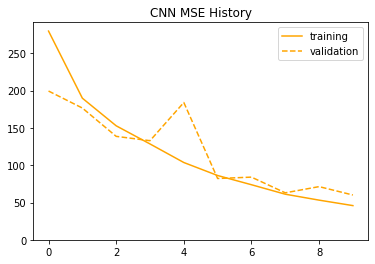

In [22]:
a = plt.plot(cnn_history.history['mse'], label='training', color='orange')
b = plt.plot(cnn_history.history['val_mse'], label='validation', color='orange', linestyle='dashed')
plt.legend()
plt.title("CNN MSE History")
ax = plt.gca()
ax.set_ylim(bottom=0)

(0.0, 299.6068071365356)

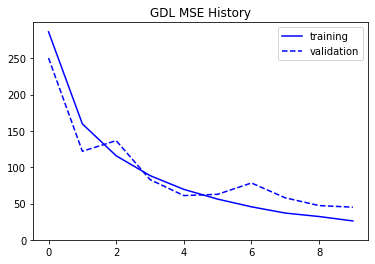

In [23]:
a = plt.plot(gdl_history.history['mse'], label='training', color='blue')
b = plt.plot(gdl_history.history['val_mse'], label='validation', color='blue', linestyle='dashed')
plt.legend()
plt.title("GDL MSE History")
ax = plt.gca()
ax.set_ylim(bottom=0)

(0.0, 299.6068071365356)

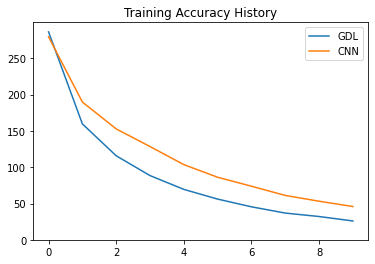

In [24]:
a = plt.plot(gdl_history.history['mse'], label='GDL')
b = plt.plot(cnn_history.history['mse'], label='CNN')
plt.legend()
plt.title("Training Accuracy History")
ax = plt.gca()
ax.set_ylim(bottom=0)

(0.0, 260.7796762466431)

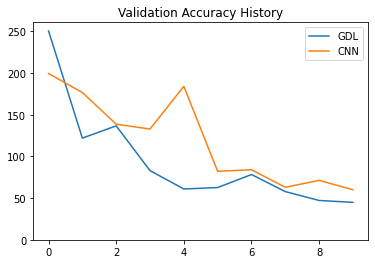

In [25]:
a = plt.plot(gdl_history.history['val_mse'], label='GDL')
b = plt.plot(cnn_history.history['val_mse'], label='CNN')
plt.title("Validation Accuracy History")
plt.legend()
ax = plt.gca()
ax.set_ylim(bottom=0)

In [26]:
gdl_model.evaluate(input_test_norm, output_test)

209/209 [==============================] - 5s 23ms/step - loss: 27.9708 - mse: 27.5662


[27.97079849243164, 27.566150665283203]

In [27]:
cnn_model.evaluate(input_test_norm, output_test)

209/209 [==============================] - 1s 6ms/step - loss: 39.1611 - mse: 38.9415


[39.16112518310547, 38.94148635864258]

In [28]:
gdl_model.predict(input_test_norm[0:10])

1/1 [==============================] - 1s 561ms/step


array([[19.776388 ,  7.9854727],
       [28.630253 , 10.592123 ],
       [29.40041  , 15.09157  ],
       [ 6.470605 ,  4.738546 ],
       [ 6.0153537,  4.646832 ],
       [10.648297 ,  5.5365953],
       [11.0851   ,  5.687889 ],
       [ 4.7435985,  3.9123137],
       [ 9.732853 ,  6.459188 ],
       [ 7.70071  ,  5.421033 ]], dtype=float32)

In [29]:
output_test.values[0:10]

array([[20.49731,  7.02307],
       [34.9656 , 11.17857],
       [27.58026, 20.06755],
       [ 7.03832,  4.37047],
       [ 4.6188 ,  4.06175],
       [ 4.6188 ,  4.02658],
       [ 7.45804,  5.48601],
       [ 4.89898,  4.     ],
       [ 8.6879 ,  5.59847],
       [ 7.54321,  5.42908]])

In [30]:
cnn_model.predict(input_test_norm[0:10])

1/1 [==============================] - 0s 75ms/step


array([[19.101244 ,  8.013058 ],
       [32.808456 ,  9.136294 ],
       [29.023716 , 15.952964 ],
       [ 4.5028076,  4.2107615],
       [ 5.411007 ,  4.44318  ],
       [ 7.629791 ,  5.3821077],
       [ 7.941971 ,  4.149328 ],
       [ 6.0151105,  3.767266 ],
       [ 8.504858 ,  5.600668 ],
       [ 7.1082654,  4.706374 ]], dtype=float32)